In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Imports 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary 
import onnx 
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
import random
import os
import datetime
import matplotlib.pyplot as plt

# Dataset Class

In [2]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Data Loaders

In [3]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(256,256),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):

    # Collect file lists
    image_files, mask_files = [], []
    for img_dir, msk_dir in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(img_dir,f) for f in os.listdir(img_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(msk_dir,f) for f in os.listdir(msk_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {img_dir}"
        image_files.extend(imgs)
        mask_files.extend(msks)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    train_ratio, val_ratio, test_ratio = split_ratio
    train_imgs, temp_imgs, train_msks, temp_msks = train_test_split(
        image_files, mask_files, test_size=(1-train_ratio), random_state=random_state)
    val_prop = val_ratio/(val_ratio+test_ratio)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        temp_imgs, temp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total images: {len(image_files)}")
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Transforms and Dataset
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    train_ds = SaliencyDataset(train_imgs, train_msks, transform)
    val_ds   = SaliencyDataset(val_imgs,   val_msks,   transform)
    test_ds  = SaliencyDataset(test_imgs,  test_msks,  transform)

    train_loader = DataLoader(train_ds, batch_size=batch_sizes[0], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_sizes[1], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_sizes[2], shuffle=False)

    return train_loader, val_loader, test_loader


# Defined Models 

In [5]:
class Saliency_IR_v1(nn.Module):
    def __init__(self):
        super(Saliency_IR_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class Saliency_IR_v2(nn.Module):
    def __init__(self):
        super(Saliency_IR_v2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training Setup

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.dice(inputs, targets)


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=100, log_prefix="exp", device="cuda"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)

    train_losses, val_losses, lrs = [], [], []
    best_val_loss = float('inf')
    best_model_path = os.path.join(log_dir, "best_model.pth")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Saved best model at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.grid(True)
    plt.savefig(os.path.join(log_dir, "loss_plot.png"))
    plt.show()

    # Optionally save CSV
    with open(os.path.join(log_dir, "loss_log.csv"), "w") as f:
        f.write("epoch,train_loss,val_loss,lr\n")
        for i in range(num_epochs):
            f.write(f"{i+1},{train_losses[i]:.4f},{val_losses[i]:.4f},{lrs[i]:.6f}\n")

    return best_model_path

## Evaluation Setup

In [9]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    if visualize:
        img, gt_mask = images[0], masks[0][0]
        pred_mask = outputs[0][0]
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }

###  6 - IR combined dataset

In [10]:
# List of folders
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]

mask_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 31566
Train: 22096, Val: 4735, Test: 4735


#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.2194 | Val Loss: 0.1243
  Saved best model at epoch 1 (Val Loss: 0.1243)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1186 | Val Loss: 0.1101
  Saved best model at epoch 2 (Val Loss: 0.1101)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1067 | Val Loss: 0.0989
  Saved best model at epoch 3 (Val Loss: 0.0989)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.0965 | Val Loss: 0.0920
  Saved best model at epoch 4 (Val Loss: 0.0920)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.0912 | Val Loss: 0.0889
  Saved best model at epoch 5 (Val Loss: 0.0889)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.0867 | Val Loss: 0.0870
  Saved best model at epoch 6 (Val Loss: 0.0870)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.0844 | Val Loss: 0.0814
  Saved best model at epoch 7 (Val Loss: 0.0814)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.0817 | Val Loss: 0.0795
  Saved best model at epoch 8 (Val Loss: 0.0795)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0803 | Val 

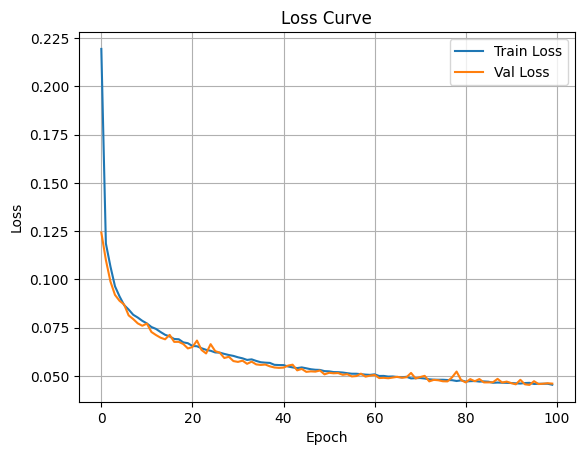


=== Evaluation Results ===
MAE            : 0.0253
Precision      : 0.6758
Recall         : 0.6135
Fβ (β²=0.3): 0.6603
Mean IoU       : 0.5694
Obj Presence R : 0.9247
Binarize thres.: 0.50
Area fraction  : 0.001000


In [12]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="IR_v2_d6_combined_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)